In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as tutils
import imageio
import pickle
import copy
from PIL import Image
import random

In [2]:
# Options being used 
batch_size = 100
imgDim = 28
path = './genImg/'
showPlot = False
savePlot = True
num_epochs = 200
IS_CUDA = False

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                     std=(0.5, 0.5, 0.5))])

In [3]:
# MNIST dataset
dataset = datasets.MNIST(root='../../Data',
                         train=True,
                         transform=transform,
                         download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


In [18]:
# Helper routines
if torch.cuda.is_available():
    IS_CUDA = True
    
def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def generate_animation(root, epoch, name):
    images = []
    for e in range(epoch):
        img_name = root+'/image_'+str(e)+'.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root+ '/' + name +'.gif', images, fps=5)

def save_image(pic, path):
    grid = torchvision.utils.make_grid(pic, nrow=8, padding=2)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

class LossModule: 
    def __init__(self, numberOfGens = 1):
        self.D_loss = []
        self.G_loss = []
        self.Many_G_loss = [[]] * (numberOfGens+1)

    def insertDiscriminatorLoss(self, lossVal):
        self.D_loss.append(lossVal)
    
    def insertGeneratorLoss(self, lossVal):
        self.G_loss.append(lossVal)
    
    def insertGeneratorList(self, lossList):
        for i in range(0, len(lossList)):
            self.Many_G_loss[i].append(lossList[i].data[0])
        
    def getDiscriminatorLoss(self):
        return self.D_loss
    
    def getGeneratorLoss(self):
        return self.G_loss
    
    def getGeneratorsList(self):
        return self.Many_G_loss
    
    def drawLossPlot(self, showPlot = False, savePlot = True, label = "Vanilla GAN Loss", genList = False):
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(label)
        if genList == True:
            i = 0
            for each in self.Many_G_loss:
                i = i + 1
                plt.plot(self.G_loss, label='Generator Loss {}'.format(i))
        else:
            plt.plot(self.G_loss, label='Generator Loss')
        plt.plot(self.D_loss, label='Discriminator Loss')
        legend = plt.legend(loc='upper right', shadow=True)

        if showPlot:
            plt.show()
        if savePlot:
            plt.savefig(label+'Loss_Plot_Vanilla_GAN_'+str(num_epochs)+'.png')

In [19]:
# Network
'''
Generator = nn.Sequential(
        nn.Linear(Generator_input, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 784),
        nn.Tanh())

Discriminator = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,1),
        nn.Sigmoid())
'''
Discriminator = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid())

Generator_input = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(Generator_input, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Sequential(nn.Linear(256, 784), nn.Tanh())
        self.lR = nn.LeakyReLU(0.2)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.lR(x)
        x = self.fc2(x)
        x = self.lR(x)
        return self.fc3(x)


#Gen = Generator()
Generators = []
GOptimizers = []
NumberOfGenerators = 3
for i in range(NumberOfGenerators):
    #Generators.append(copy.deepcopy(Generator))
    Generators.append(Generator())

if IS_CUDA:
    Discriminator.cuda()
    for each in Generators:
        each.cuda()

In [20]:
lossManager = LossModule(numberOfGens = NumberOfGenerators)
lossCriterion = nn.BCELoss()
D_opt = torch.optim.Adam(Discriminator.parameters(), lr = 0.0001)
#G_opt = torch.optim.Adam(Gen.parameters(), lr = 0.0001)
GOptimizers = []
for each in Generators:
    GOptimizers.append(torch.optim.Adam(each.parameters(), lr = 0.0001))

fixed_x = var(torch.randn(batch_size, Generator_input))

GeneratorLoss = []
def backPropGenerator(index, GeneratorLoss):
    Generators[index].zero_grad()
    GeneratorLoss[index].backward()
    GOptimizers[index].step()

In [21]:
# load model by loading from best one
outputImages = []
def train(BestPerformingGenerator, num_epochs = 10, d_iter = 1):
    for epoch in range(num_epochs):
        lossList = [0.0] * NumberOfGenerators
        for data in data_loader:
            image, _  = data
            image = var(image.view(image.size(0),  -1))
            
            # Train Discriminator
            # for k in range(0, d_iter):
            # for each in Generators:
            D_real = Discriminator(image)
            # For Log(1 - D(G(Z)))
            Z_noise = var(torch.randn(batch_size, Generator_input))
            #print Z_noise.shape
            #print type(Gen)
            G_fake = Generators[BestPerformingGenerator](Z_noise) #each(Z_noise) 
            #print G_fake.shape
            D_fake = Discriminator(G_fake)

            # Calculate Discriminator Loss
            D_real_loss = lossCriterion(D_real, var(torch.ones(batch_size, 1)))
            D_fake_loss = lossCriterion(D_fake, var(torch.zeros(batch_size, 1)))
            D_loss = D_real_loss + D_fake_loss

            # Backprop Discriminator
            Discriminator.zero_grad()
            D_loss.backward()
            D_opt.step()
            # print 'Discriminator Loop for: {}: {}'.format(i, D_loss.data[0])
   
            # Find best performing Generator
            i = 0
            GeneratorLoss = []
            for each, each_opt in zip(Generators, GOptimizers):
                Z_noise = var(torch.randn(batch_size, Generator_input))
                G_fake = each(Z_noise)
                #print G_fake1.shape
                #print type(each)
                D_fake = Discriminator(G_fake)
                # Compute Generator Loss
                G_loss = lossCriterion(D_fake, var(torch.ones(batch_size, 1)))
                GeneratorLoss.append(G_loss)
                lossList[i] += (float(G_loss.data[0]))
                i = i + 1
                Discriminator.zero_grad()
                each.zero_grad()
                G_loss.backward()
                each_opt.step()

        BestPerformingGenerator = random.randint(0, NumberOfGenerators-1)    
        for i in range(0, NumberOfGenerators):
            if i != BestPerformingGenerator:
                prev = Generators[i]
                Generators[i] = Generator()
                if IS_CUDA:
                    Generators[i].cuda()
                Generators[i].load_state_dict(Generators[BestPerformingGenerator].state_dict())
                GOptimizers[i] = torch.optim.Adam(Generators[i].parameters(), lr = 0.0001)
                GOptimizers[i].load_state_dict(GOptimizers[BestPerformingGenerator].state_dict())
                if Generators[i] == prev:
                    print 'ERROR: Generator unchanged'


        print '{} Epoch [{}/{}], Discriminator {:.4f}, Best Generator[{}] {:.4f}'.format(BestPerformingGenerator, epoch+1, num_epochs, D_loss.data[0], BestPerformingGenerator, GeneratorLoss[BestPerformingGenerator].data[0])
        lossManager.insertDiscriminatorLoss(D_loss.data[0])
        lossManager.insertGeneratorLoss(G_loss.data[0])
        # lossManager.insertGeneratorList(GeneratorLoss)
        pic = Generators[BestPerformingGenerator](fixed_x)
        pic = pic.view(pic.size(0), 1, 28, 28) 
        pic = denorm(pic.data)
        outputImages.append(pic)
        #torchvision.utils.save_image(pic, path+'image_{}.png'.format(epoch))
        save_image(pic, path+'image_{}.png'.format(epoch))
    return BestPerformingGenerator

In [22]:
num_epochs = 200
BestPerformingGenerator = train(0, num_epochs)

[1096.5004920363426, 998.9493336081505, 1034.7462167739868]
0 Epoch [1/200], Discriminator 0.2313, Best Generator[0] 3.0185
[1772.50100004673, 1771.86940908432, 1770.9822174310684]
0 Epoch [2/200], Discriminator 0.2273, Best Generator[0] 3.5742
[1754.383185505867, 1777.878063082695, 1767.4357472658157]
1 Epoch [3/200], Discriminator 0.1790, Best Generator[1] 2.7708


KeyboardInterrupt: 

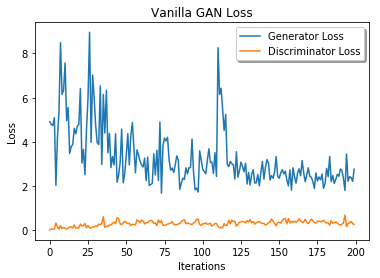

In [15]:
# Plot the Loss for Generator and Discriminator
lossManager.drawLossPlot(showPlot = True, savePlot = False)

In [70]:
#lossL = lossManager.getGeneratorsList()

In [16]:
# Generate GIF
generate_animation(path, num_epochs, 'Max_Multiple_Gens')

In [18]:
# Save the model
torch.save(Generators[BestPerformingGenerator].state_dict(), './Generator.pkl')
torch.save(Discriminator.state_dict(), './Discriminator.pkl')
pickle.dump(lossManager, open( "LossManager.pkl", "wb" ))

In [74]:
# Load Loss Manager for viewing data of 200 iterations
#lossManagerTrained = pickle.load(open( "200Iteration/LossManager.pkl", "rb" ))

In [87]:
#drawLossPlot(lossManagerTrained.getGeneratorLoss(), lossManagerTrained.getDiscriminatorLoss(), showPlot = False, savePlot = True, loc = "200Iteration")
#drawLossPlot(lossManagerTrained.getGeneratorLoss(), lossManagerTrained.getDiscriminatorLoss(), showPlot = True, savePlot = False, loc = "200Iteration")

In [2]:
# Load model for debugging and testing
#Generator.load_state_dict(torch.load('Generator200.pkl'))
#Discriminator.load_state_dict(torch.load('Discriminator200.pkl'))